## Examine BLIP-2 from LAVIS and Setup Fine-Tuning

Uses 3.11 environment locally

In [ ]:
import torch
from lavis.models import model_zoo
from PIL import Image

In [2]:
print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

We want the feature extractor. We will take the pre-trained model and fine-tune it.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from lavis.models import load_model_and_preprocess
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=True, device=device)

In [8]:
model

Blip2Qformer(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-38): 39 x Block(
        (norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1408, out_features=4224, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1408, out_features=1408, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1408, out_features=6144, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )


In [17]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

186705470

The model provides image and text pre-processors that have both train and eval modes. The image processor behaves differently in the two modes, but the text processor appears to behave the same.

In [5]:
img = Image.open('../../assets/sofa.jpg').convert('RGB')

In [6]:
vis_processors['train'](img)

tensor([[[ 0.9230, -0.3178, -1.1353,  ...,  0.0763,  0.0763,  0.0763],
         [-0.3616, -1.2083, -0.8726,  ...,  0.0763,  0.0763,  0.0763],
         [-0.3178, -0.5660,  0.2807,  ...,  0.0763,  0.0763,  0.0763],
         ...,
         [ 1.1566,  1.0398,  0.7479,  ...,  0.0763,  0.0763,  0.0763],
         [ 0.1785,  0.5289,  0.6749,  ...,  0.0763,  0.0763,  0.0763],
         [-1.2959, -0.3470,  0.4997,  ...,  0.0763,  0.0763,  0.0763]],

        [[ 0.6491, -0.7016, -1.5270,  ...,  0.1689,  0.1689,  0.1689],
         [-0.6565, -1.5720, -1.2568,  ...,  0.1689,  0.1689,  0.1689],
         [-0.5815, -0.8666,  0.0338,  ...,  0.1689,  0.1689,  0.1689],
         ...,
         [ 0.9793,  0.8442,  0.5291,  ...,  0.1689,  0.1689,  0.1689],
         [-0.0112,  0.3340,  0.4691,  ...,  0.1689,  0.1689,  0.1689],
         [-1.5120, -0.5515,  0.3190,  ...,  0.1689,  0.1689,  0.1689]],

        [[ 0.5106, -0.7266, -1.4518,  ...,  0.3399,  0.3399,  0.3399],
         [-0.5701, -1.3949, -1.1958,  ...,  0

In [7]:
vis_processors['eval'](img)

tensor([[[ 0.9522,  0.9230,  0.9230,  ...,  0.7187,  0.7187,  0.7187],
         [ 0.9084,  0.8501,  0.8938,  ...,  0.7187,  0.7187,  0.7187],
         [ 0.8501,  0.7479,  0.9522,  ...,  0.7187,  0.7187,  0.7187],
         ...,
         [ 0.2515, -0.0550, -0.2156,  ...,  0.9084,  0.8647,  0.8355],
         [ 0.2807,  0.5435,  0.2953,  ...,  0.8792,  0.9376,  0.9814],
         [ 0.5289,  0.3975,  0.3975,  ...,  0.8501,  0.8355,  0.8063]],

        [[ 1.0844,  1.0544,  1.0544,  ...,  0.8593,  0.8593,  0.8593],
         [ 1.0393,  0.9793,  1.0243,  ...,  0.8593,  0.8593,  0.8593],
         [ 0.9793,  0.8743,  1.0844,  ...,  0.8593,  0.8593,  0.8593],
         ...,
         [-0.2663, -0.5815, -0.7316,  ...,  0.9193,  0.8743,  0.8442],
         [-0.2213,  0.0638, -0.1913,  ...,  0.8893,  0.9493,  0.9943],
         [ 0.0488, -0.0862, -0.0712,  ...,  0.8593,  0.8442,  0.8142]],

        [[ 1.2358,  1.2216,  1.2358,  ...,  0.8092,  0.8092,  0.8092],
         [ 1.1932,  1.1363,  1.2074,  ...,  0

In [37]:
txt_processors['train']('Hello, world!')

'hello, world'

In [8]:
txt_processors['eval']('Hello, world!')

'hello, world'

### Setup the Dataset and DataLoader

In [ ]:
from lavis.models import load_model_and_preprocess
import torch
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader
from PIL import Image
import pandas as pd

import os
from tqdm import tqdm
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We use the Google Shopping dataset, which is examined a bit in the notebook Marqo-GS-10M-EDA.

Notice that we mix up the order of the query and title in the lables so that the model doesn't get used to having the query first.

In [6]:
class GoogleShoppingDataset(Dataset):
    def __init__(self, image_dir: str, annotations_file: str, image_processor: object, text_processor: object):
        self.annotations = pd.read_csv(annotations_file)
        self.image_dir = image_dir
        self.image_processor = image_processor
        self.text_processor = text_processor
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx: int):
        image_path = os.path.join(self.image_dir, self.annotations.loc[idx, 'image_local'])
        image = Image.open(image_path).convert('RGB')
        image = self.image_processor(image)
        label_options = (self.annotations.loc[idx, 'query'] + ': ' + self.annotations.loc[idx, 'title'], 
                         self.annotations.loc[idx, 'title'] + ': ' + self.annotations.loc[idx, 'query'])
        label = random.choice(label_options)
        label = self.text_processor(label)
        return image, label

We need the sample weights (inverse of how often an item appears in the dataset and how big its group is) to use WeightedRandomSampler below, which we use because the dataset is imbalanced.

In [ ]:
def get_sample_weights_gs(annotations_file: str):
    annotations_df = pd.read_csv(annotations_file)
    query_counts = annotations_df['query_id'].value_counts()
    query_counts_full = query_counts[annotations_df['query_id']].to_numpy()
    product_counts = annotations_df['product_id'].value_counts()
    product_counts_full = product_counts[annotations_df['product_id']].to_numpy()
    weights = 1 / ( query_counts_full * product_counts_full)
    return weights

Build the dataloaders based on the GoogleShoppingDataset class.

Note that I only let the number of samples in WeightedRandomSampler to the size of the original dataset, as it's going to take more than a day to get through all those already.

In [ ]:
def build_gs_dataloader(images_dir: str, annotations_file: str, image_processor: callable, 
                     text_processor: callable, seed=42, batch_size=64, num_workers=2) -> DataLoader:
    dataset = GoogleShoppingDataset(image_dir=images_dir, annotations_file=annotations_file,
                                      image_processor=image_processor, text_processor=text_processor)
    weights = get_sample_weights_gs(annotations_file)
    generator = torch.Generator().manual_seed(seed)
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True, generator=generator)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    return dataloader

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=False, device=device)
images_dir = '/mnt/d/marqo-gs-10m/images'
train_annotations = '/mnt/d/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_0_product_id_0.csv'
val_annotations = '/mnt/d/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_1_product_id_1.csv'

train_dataloader = build_gs_dataloader(images_dir=images_dir, annotations_file=train_annotations,
                                    image_processor=vis_processors['train'],
                                    text_processor=txt_processors['train'], seed=42,
                                    batch_size=24, num_workers=2)
val_dataloader = build_gs_dataloader(images_dir=images_dir, annotations_file=val_annotations,
                                    image_processor=vis_processors['eval'],
                                    text_processor=txt_processors['eval'], seed=42,
                                    batch_size=24, num_workers=2)

#### Setup Model for Q-former Fine-Tuning

AdamW was used to train the model, so use it again here along with the parameters used for the original pretraining.

In [7]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-5, betas=(0.9, 0.999), weight_decay=0.05)

We must run the code in distributed mode, even if we're just running on one GPU. The code looks like it was partially setup to allow for local runs, but some distributed code did not get properly wrapped.

In [8]:
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29500'
torch.distributed.init_process_group(backend="nccl", world_size=1, rank=0)

The training loop.

Note that we need to use autocast because it's used in the model code.

In [3]:
def train(model, dataloader, device, optimizer, epochs):
    losses = []
    running_loss = 0
    
    scaler = torch.GradScaler()
    model.train()
    for epoch in range(epochs): 
        for i, data in enumerate(tqdm(dataloader)):
            images, labels = data
            images = images.to(device)
            samples = {"image": images, "text_input": labels}
            
            optimizer.zero_grad()
            with torch.autocast(device_type=device):
                output = model(samples)
            scaler.scale(output.loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += output.loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000
                losses.append(last_loss)
                print(f'  batch {i+1} loss: {last_loss}')
                running_loss = 0
                
    return losses

The validation loop.

In [15]:
@torch.no_grad()
def validate(model, dataloader, device):
    losses = []
    running_loss = 0
    
    model.eval()
    for i, data in enumerate(tqdm(dataloader)):
        images, labels = data
        images = images.to(device)
        samples = {"image": images, "text_input": labels}
        with torch.autocast(device_type=device):
            output = model(samples)
        running_loss += output.loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            losses.append(last_loss)
            print(f'  batch {i+1} loss: {last_loss}')
            running_loss = 0
            
        return losses

In [ ]:
losses_train = train(model=model, dataloader=train_dataloader, device=device, optimizer=optimizer, epochs=1)

In [ ]:
losses_validate = validate(model=model, dataloader=val_dataloader, device=device)

Plot the training loss vs batch for every 1000 batches. Also plot the average validation loss after training as a horizontal line.

Text(0.5, 0, 'Training Batch (x1000)')

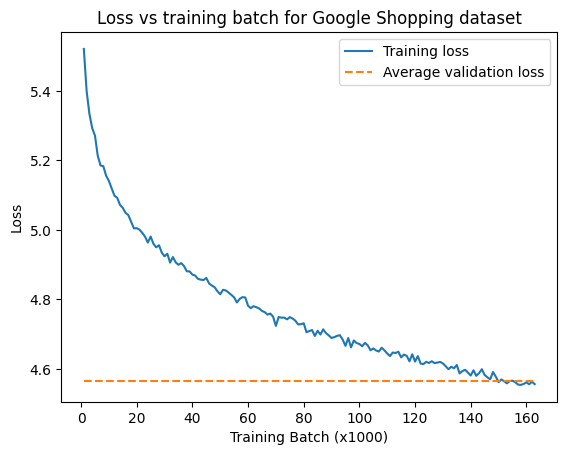

In [12]:
import pickle
import matplotlib.pyplot as plt

with open('/mnt/d/marqo-gs-10m/model-saves/pretrain_1epoch_loss', 'rb') as f:
    train_loss = pickle.load(f)

with open('/mnt/d/marqo-gs-10m/model-saves/validate_final_loss', 'rb') as f:
    validate_loss = pickle.load(f)

avg_validate_loss = sum(validate_loss)/len(validate_loss)

batch = list(range(1, len(train_loss) + 1))
plt.plot(batch, train_loss)
plt.plot(batch, [avg_validate_loss]*len(batch), '--')
plt.legend(['Training loss', 'Average validation loss'])
plt.title('Loss vs training batch for Google Shopping dataset')
plt.ylabel('Loss')
plt.xlabel('Training Batch (x1000)')

#### Try Fine-Tuning Whole Thing (Including Vision Transformer)

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="coco", is_eval=False, device=device)
images_dir = '/mnt/d/marqo-gs-10m/images'
train_annotations = '/mnt/d/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_0_product_id_0.csv'
val_annotations = '/mnt/d/marqo-gs-10m/marqo-gs-dataset/marqo_gs_full_10m/query_1_product_id_1.csv'

train_dataloader = build_gs_dataloader(images_dir=images_dir, annotations_file=train_annotations,
                                    image_processor=vis_processors['train'],
                                    text_processor=txt_processors['train'], seed=42,
                                    batch_size=2, num_workers=2)
val_dataloader = build_gs_dataloader(images_dir=images_dir, annotations_file=val_annotations,
                                    image_processor=vis_processors['eval'],
                                    text_processor=txt_processors['eval'], seed=42,
                                    batch_size=2, num_workers=2)

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

1173191358

In [11]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-5, betas=(0.9, 0.999), weight_decay=0.05)

In [12]:
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29500'
torch.distributed.init_process_group(backend="nccl", world_size=1, rank=0)

In [ ]:
losses_train = train(model=model, dataloader=train_dataloader, device=device, optimizer=optimizer, epochs=1)

In [ ]:
losses_validate = validate(model=model, dataloader=val_dataloader, device=device)

It turns out that I don't have enough video RAM for fine-tuning with the vision transformer on my local machine. I tried fine-tuning on AWS, and got it to work on an L40S GPU with 48GB RAM (G6e.xlarge instance), but it would have taken around 100 hours. At $1.861/hr, I figured that Interview Kickstart would not be happy with me if I tried it. While I could have just done the ABO dataset, the instructor expressed concerns about fine-tuning with that dataset given that there is text that goes beyond a product description in that dataset (the bullet points). There were also further complications, such as a warm-up of the learning rate and learning rate decay for the vision transformer, which would have taken time to implement. If we were to continue working with this agent, fine-tuning with the vision transformer would be an additional goal.

#### Try fine-tuning with the ABO dataset

We just need to re-write the dataset class the get_sample_weights function, and the dataloader builder. All the rest should be re-usable from fine-tuning on the Google Shopping dataset.

I use the dataset without the product type checking so that I don't have to drop a bunch of data that I haven't analyzed. Since it's just a word or three amongst many, I don't think it should make much of a differenece. If I wanted to be thorough, I would check with and without the product type checking, but I don't have time for that.

In [4]:
class ABODataset(Dataset):
    def __init__(self, image_dir: str, metadata: pd.DataFrame,
                 image_metadata: pd.DataFrame, image_item_pairs: pd.DataFrame,
                 image_processor: callable, text_processor: callable):
        self.image_dir = image_dir
        self.metadata = metadata
        self.image_metadata = image_metadata
        self.image_processor = image_processor
        self.text_processor = text_processor
        self.image_item_pairs = image_item_pairs
        
        self._drop_unwanted_metadata_columns()
        random.seed(42)
        
    def _drop_unwanted_metadata_columns(self):
        self.metadata = self.metadata.drop(columns=['item_weight', 'main_image_id',
                                                    'other_image_id', 'country',
                                                    'marketplace', 'domain_name'])    
     
    def __len__(self):
        return len(self.image_item_pairs)
    
    def __getitem__(self, idx: int):
        image_id = self.image_item_pairs.loc[idx, 'image_id']
        item_id = self.image_item_pairs.loc[idx, 'item_id']
        image_path = os.path.join(self.image_dir, self.image_metadata.loc[image_id, 'path'])
        image = Image.open(image_path).convert('RGB')
        image = self.image_processor(image)
        label = self._row_to_str(self.metadata.loc[item_id])
        label = self.text_processor(label)
        return image, label
    
    def _row_to_str(self, row):
        row_filtered = row.dropna()
        heading_data_pairs = list(zip(row_filtered.index, row_filtered))
        random.shuffle(heading_data_pairs)  # so that the model doesn't get used to an order
        text = []
        for heading, item in heading_data_pairs:
            text.append(heading.replace('_', ' ') + ':')
            if isinstance(item, list):
                text.extend(item)
            else:
                text.append(str(item))
        
        return ' '.join(text).replace('\n', ' ')


In [5]:
def abo_image_item_pairs(metadata: pd.DataFrame) -> pd.DataFrame:
    image_ids = []
    item_ids = []
    for item_id in metadata.index:
        main_image_id = metadata.loc[item_id, 'main_image_id']
        if not pd.isna(main_image_id):
            image_ids.append(main_image_id)
            item_ids.append(item_id)
        other_image_ids = metadata.loc[item_id, 'other_image_id']
        if isinstance(other_image_ids, list):
            for other_image_id in other_image_ids:
                image_ids.append(other_image_id)
                item_ids.append(item_id)
        elif not pd.isna(other_image_ids):
            image_ids.append(other_image_ids)
            item_ids.append(item_id)
    return pd.DataFrame({'image_id': image_ids, 'item_id': item_ids})

Get the sample weights to balance the dataset by using the number of items per product type and the number of images per item. Directly doing this calculation without joins could be difficult, but I can take care of both by doing a left join of the image_item_pairs with the metadata table on the item_id, then counting the frequency of each product_type.

Some images go with multiple items also, but that's correlated with the items per product type, so I'm going to leave it out. Incidentally, that's also why I need to use a join rather than nested dataframe accesses.

In [6]:
def get_sample_weights_abo(metadata: pd.DataFrame, image_item_pairs: pd.DataFrame) -> list:
    joined = image_item_pairs.join(metadata, on='item_id')
    product_type_counts = joined['product_type'].value_counts()
    product_type_counts_full = product_type_counts[joined['product_type']].to_numpy()
    weights = 1 / product_type_counts_full
    return weights

In [7]:
def build_abo_dataloader(images_dir: str, metadata_file: str, image_metadata_file: str, 
                         image_processor: callable, text_processor: callable, seed=42, 
                         batch_size=64, num_workers=2) -> DataLoader:
    metadata = pd.read_pickle(metadata_file)
    image_metadata = pd.read_csv(image_metadata_file).set_index('image_id')
    image_item_pairs = abo_image_item_pairs(metadata)
    dataset = ABODataset(images_dir, metadata, image_metadata, image_item_pairs,
                         image_processor, text_processor)
    weights = get_sample_weights_abo(metadata, image_item_pairs)
    generator = torch.Generator().manual_seed(seed)
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True, generator=generator)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
    return dataloader

I thought about how I might build a validation set, and there's no good way to do so here. Images are shared across multiple products, so just randomly sampling a subset of the items would still result in "cheating." I also can't take a subset of the products, as some of the categories are very broad and some are very large, so I might leave out critical training data or end up with a validation set much larger than I would like. There might be a way to build one based off of randomly selecting images, but again, given that an image can be used across multiple products, that gets complicated, and I don't have time time to write code for it right now. Therefore, I am simply going to go without, and we'll determine the best model when testing the agent.

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_feature_extractor", model_type="pretrain", is_eval=False, device=device)
images_dir = '/mnt/d/abo-dataset/images/small'
metadata_file = '/mnt/d/abo-dataset/abo-listings-english-fixed-product-type.pkl'
image_metadata_file = '/mnt/d/abo-dataset/images/metadata/images.csv'

train_dataloader = build_abo_dataloader(images_dir, metadata_file, image_metadata_file,
                                    image_processor=vis_processors['train'],
                                    text_processor=txt_processors['train'], seed=42,
                                    batch_size=24, num_workers=2)

In [9]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-5, betas=(0.9, 0.999), weight_decay=0.05)

In [10]:
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29500'
torch.distributed.init_process_group(backend="nccl", world_size=1, rank=0)

In [ ]:
losses_train = train(model=model, dataloader=train_dataloader, device=device, optimizer=optimizer, epochs=1)

Plot the training loss vs batch for every 1000 batches. No validation set for this one, as discussed above.

Text(0.5, 0, 'Training Batch (x1000)')

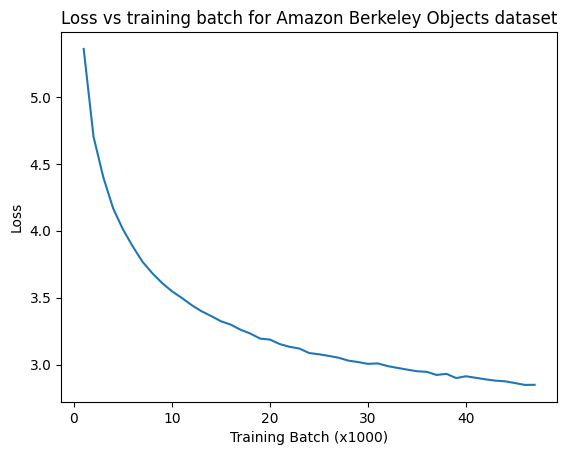

In [13]:
import pickle
import matplotlib.pyplot as plt

with open('/mnt/d/abo-dataset/model_saves/pretrain_2epochs_loss', 'rb') as f:
    train_loss = pickle.load(f)

batch = list(range(1, len(train_loss) + 1))
plt.plot(batch, train_loss)
plt.title('Loss vs training batch for Amazon Berkeley Objects dataset')
plt.ylabel('Loss')
plt.xlabel('Training Batch (x1000)')